## TensorBoard로 모델, 데이터, 학습 시각화하기

PyTorch는 신경망 학습 내역을 시각화하는 도구인 TensorBoard와 통합되어 쉽게 사용할 수 있다. 해당 기능을 간단히 살펴보도록 하자.

### 기본 세팅

데이터셋을 로드하고, 이를 위한 몇 가지 헬퍼 함수를 정의한 후 기본적인 네트워크를 구축해보도록 하자.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

In [4]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [5]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

`Fashion-MNIST` 데이터셋은 `CIFAR10`과 달리 28x28 사이즈이므로 이에 맞게 네트워크를 정의해야한다. (혹은 resize를 통해 데이터의 크기를 변경해줘야 한다.)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6, 16,5)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # (((28-4)/2)-4)/2 = 4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### TensorBoard 설정

이제 `torch.utils`의 `tensorboard`를 불러오고, TensorBoard에 정보를 제공하는 `SummaryWriter`를 정의하여 TensorBoard를 설정해보자.

기본 `logdir`은 `runs`이며 별도로 지정할 수 있다. 

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

### TensorBoard에 기록하기

이제 `make_grid`를 사용하여 TensorBoard에 이미지를 write 해보도록 하자.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


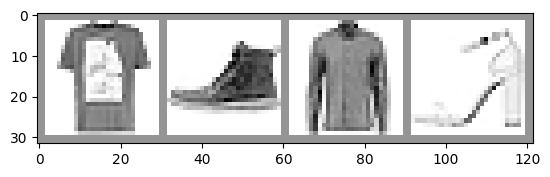

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

image_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(image_grid, one_channel=True)

# TensorBoard에 기록
writer.add_image('four_fashion_mnist_samples', image_grid)

TensorBoard는 다음 명령어를 실행한 후 출력되는 url에서 확인할 수 있다. (localhost 6006 포트에 TensorBoard가 뜬다.)

In [10]:
# !tensorboard --logdir=runs

### TensorBoard로 모델 분석(inspect)하기

TensorBoard의 강점 중 하나는 복잡한 모델 구조를 시각화 할 수 있다는 점이다.

PyTorch는 동적 그래프 방식을 채택하고 있기 때문에, 계산 그래프를 만들기 위해서는 샘플 데이터를 흘려보내주는 과정이 필요하다.

In [11]:
writer.add_graph(net, images)
writer.close()

<img width="800" alt="fashion_mnist_experiment_1" src="https://github.com/KevinTheRainmaker/Pytorch_DeepLearning/assets/76294398/2458db1c-3047-40d1-a687-617c81f8656e">

### TensorBoard에 Projector 추가하기

`add_embedding` 메서드를 통해 고차원 데이터의 저차원 표현을 시각화할 수 있다.

In [12]:
def select_n_random(data, labels, n=100):
    '''
    Select n-random datapoints and labels from dataset
    '''
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data)) # 0~len(data) 사이 정수를 무작위로 섞어서 텐서 만들기
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

# 각 이미지의 class label 가져오기
class_labels = [classes[label] for label in labels]

# embedding 내역 기록
features = images.view(-1,28*28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

TensorBoard를 Reload하면 Projector 탭이 생긴 것을 확인할 수 있다. 해당 탭을 확인하면 앞서 선택한 랜덤 100개의 이미지가 3차원 공간에 투사된 것을 확인할 수 있다. 

TensorBoard는 interactive한 기능들을 제공하기 때문에 클릭, 드래그 등으로 투영을 조작할 수 있으며 `Color by: label` 옵션을 이용하면 좀더 선명하게 볼 수 있다.

<img width="800" alt="image" src="https://github.com/KevinTheRainmaker/Pytorch_DeepLearning/assets/76294398/6c0417ca-b1e3-4b62-a92b-976ec0e9659c">

### TensorBoard로 모델 학습 추적하기

TensorBoard에 loss plot을 추가하도록 하고, 배치에 대해 예측 결과를 시각화할 수 있도록 해보자.

이를 위해서는 두 개의 헬퍼 함수가 필요하며, `add_scalar` 함수를 통해 TensorBoard에 결과를 기록한다.

In [16]:
# helper functions

def imgs_to_probs(net, imgs):
    '''
    generate preds and probs using trained network
    '''
    output = net(imgs)
    # convert output probs to predicted class  
    _, preds_tensor = torch.max(output, 1) # torch.max(output, dim=1) -> prob vals, prob indices
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_cls_preds(net, imgs, labels):
    '''
    generate matplotlib figure using imgs/labels from trained net
    color indicates the preds are right or wrong
    '''
    preds, probs = imgs_to_probs(net, imgs)
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(imgs[idx], one_channel=True)
        ax.set_title(f'{classes[preds[idx]]}, {probs[idx]*100.0:.1f}%\n(label: {classes[labels[idx]]})',
                     color=('green' if preds[idx]==labels[idx].item() else 'red'))
    return fig

In [19]:
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        optimizer.zero_grad()
        
        # FeedForward + BackProp + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            writer.add_scalar('trainning_loss',
                              running_loss / 1000,
                              epoch * len(trainloader)+i)
                
            writer.add_figure('predictions vs. actuals',
                            plot_cls_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader)+i)
            running_loss = 0.0
print('Finished Training')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


이제 TensorBoard의 Scalars 탭에서 loss plot을 확인할 수 있다.

<img width="600" alt="image" src="https://github.com/KevinTheRainmaker/Pytorch_DeepLearning/assets/76294398/09b578ce-1916-454e-a9a5-4d4335805b71">


또한 앞서 보았던 배치 단위 예측 결과도 TensorBoard의 Images 탭에서 확인할 수 있다.
<img width="800" alt="image" src="https://github.com/KevinTheRainmaker/Pytorch_DeepLearning/assets/76294398/986a6536-0556-4f37-bdf5-c53dd3796d16">